In [1]:
from functools import reduce

import ujson
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

import config
config.config_visuals()

# Load splicing results

In [40]:
def concat_cols(df, cols, delim):
    cols_str = [df[x].astype(str) for x in cols]

    return reduce(lambda a, b: a + delim + b, cols_str)


def load_se(experiment):
    se = pd.read_csv(
        f"../data/raw/rmats_output/{experiment}/SE.MATS.JC.txt", sep="\t", index_col=0
    )

    se["exon_length"] = se["exonEnd"] - se["exonStart_0base"]

    se["exon_id"] = concat_cols(
        se,
        [
            "chr",
            "exonStart_0base",
            "exonEnd",
            "upstreamES",
            "upstreamEE",
            "downstreamES",
            "downstreamEE",
        ],
        "_",
    )

    se = se.set_index("exon_id")
    se = se.sort_values(by="FDR")

    return se


def load_mxe(experiment):
    mxe = pd.read_csv(
        f"../data/raw/rmats_output/{experiment}/MXE.MATS.JC.txt", sep="\t", index_col=0
    )

    mxe["exon_length"] = mxe["2ndExonEnd"] - mxe["1stExonStart_0base"]

    mxe["exon_id"] = concat_cols(
        mxe,
        [
            "chr",
            "1stExonStart_0base",
            "1stExonEnd",
            "2ndExonStart_0base",
            "2ndExonEnd",
            "upstreamES",
            "upstreamEE",
            "downstreamES",
            "downstreamEE",
        ],
        "_",
    )

    mxe = mxe.set_index("exon_id")
    mxe = mxe.sort_values(by="FDR")

    return mxe


rpl22_oe_se = load_se("rpl22_oe")
rpl22l1_oe_se = load_se("rpl22l1_oe")
rpl22l1_kd1_se = load_se("rpl22l1_kd1")
rpl22l1_kd2_se = load_se("rpl22l1_kd2")
rpl22_a_ko1_se = load_se("rpl22_a_ko1")
rpl22_a_ko2_se = load_se("rpl22_a_ko2")
rpl22_b_ko1_se = load_se("rpl22_b_ko1")
rpl22_b_ko2_se = load_se("rpl22_b_ko2")

rpl22l1_oe_mxe = load_mxe("rpl22l1_oe")

In [37]:
mxe = pd.read_csv(f"../data/raw/rmats_output/{'rpl22l1_oe'}/MXE.MATS.JC.txt", sep="\t", index_col=0)

(array([5.202e+03, 2.890e+02, 8.400e+01, 3.200e+01, 1.500e+01, 1.400e+01,
        7.000e+00, 1.000e+00, 0.000e+00, 3.000e+00]),
 array([1.130000e+02, 1.939570e+04, 3.867840e+04, 5.796110e+04,
        7.724380e+04, 9.652650e+04, 1.158092e+05, 1.350919e+05,
        1.543746e+05, 1.736573e+05, 1.929400e+05]),
 <BarContainer object of 10 artists>)

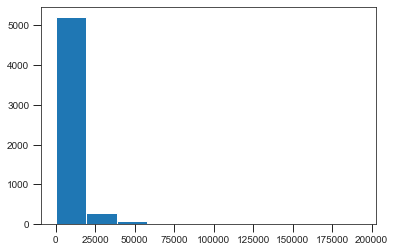

In [44]:
plt.hist(rpl22l1_oe_mxe["exon_length"])

# Extract SE intervals

In [30]:
def output_diff_se(exon_set, filter_set, output_name, padding):

    exon_set = exon_set.copy(deep=True)

    # remove "chr" prefixes
    exon_set["chr"] = exon_set["chr"].apply(lambda x: x[3:])
    exon_set["start"] = exon_set["exonStart_0base"] - padding
    exon_set["end"] = exon_set["exonEnd"] + padding
    exon_set["id"] = range(len(exon_set))
    exon_set["id"] = exon_set["geneSymbol"] + "_" + exon_set["id"].astype(str)

    pos_exons = exon_set[filter_set]
    neg_exons = exon_set[~filter_set]

    print(f"Positive exons: {len(pos_exons)}")
    print(f"Negative exons: {len(neg_exons)}")

    pos_exons[["chr", "start", "end", "id", "exon_length", "strand"]].to_csv(
        f"../data/intermediate/extracted_sequences/{output_name}_pos.bed",
        sep="\t",
        header=False,
        index=False,
    )
    neg_exons[["chr", "start", "end", "id", "exon_length", "strand"]].to_csv(
        f"../data/intermediate/extracted_sequences/{output_name}_neg.bed",
        sep="\t",
        header=False,
        index=False,
    )

    


output_diff_se(
    rpl22l1_oe_se,
    rpl22l1_oe_se["FDR"] < 0.01,
    "RPL22L1_OE_SE",
    padding=100,
)
output_diff_se(
    rpl22l1_kd1_se,
    (rpl22l1_kd1_se["FDR"] < 0.01) & (rpl22l1_kd2_se["FDR"] < 0.01),
    "RPL22L1_KD_SE",
    padding=100,
)
output_diff_se(
    rpl22_a_ko1_se,
    (rpl22_a_ko1_se["FDR"] < 0.01) & (rpl22_a_ko2_se["FDR"] < 0.01),
    "RPL22_A_KO_SE",
    padding=100,
)
output_diff_se(
    rpl22_b_ko1_se,
    (rpl22_b_ko1_se["FDR"] < 0.01) & (rpl22_b_ko2_se["FDR"] < 0.01),
    "RPL22_B_KO_SE",
    padding=100,
)

Positive exons: 1362
Negative exons: 38296


<ipython-input-30-d40287f445d6>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pos_exons = exon_set[filter_set]
<ipython-input-30-d40287f445d6>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neg_exons = exon_set[~filter_set]


Positive exons: 109
Negative exons: 36360


<ipython-input-30-d40287f445d6>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pos_exons = exon_set[filter_set]
<ipython-input-30-d40287f445d6>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neg_exons = exon_set[~filter_set]


Positive exons: 161
Negative exons: 59646
Positive exons: 82
Negative exons: 54268


<ipython-input-30-d40287f445d6>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pos_exons = exon_set[filter_set]
<ipython-input-30-d40287f445d6>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neg_exons = exon_set[~filter_set]


In [49]:
def output_diff_mxe(exon_set, filter_set, output_name, padding):

    exon_set = exon_set.copy(deep=True)

    # remove "chr" prefixes
    exon_set["chr"] = exon_set["chr"].apply(lambda x: x[3:])
    exon_set["start_1"] = exon_set["1stExonStart_0base"] - padding
    exon_set["end_1"] = exon_set["1stExonEnd"] + padding
    exon_set["start_2"] = exon_set["2ndExonStart_0base"] - padding
    exon_set["end_2"] = exon_set["2ndExonEnd"] + padding
    exon_set["id"] = range(len(exon_set))
    exon_set["id"] = exon_set["geneSymbol"] + "_" + exon_set["id"].astype(str)

    pos_exons = exon_set[filter_set]
    neg_exons = exon_set[~filter_set]

    pos_exons_1 = pos_exons.drop(["start_2", "end_2"],axis=1)
    pos_exons_1 = pos_exons_1.rename({"start_1": "start", "end_1": "end"}, axis=1)
    pos_exons_2 = pos_exons.drop(["start_1", "end_1"],axis=1)
    pos_exons_2 = pos_exons_2.rename({"start_2": "start", "end_2": "end"}, axis=1)

    neg_exons_1 = neg_exons.drop(["start_2", "end_2"],axis=1)
    neg_exons_1 = neg_exons_1.rename({"start_1": "start", "end_1": "end"}, axis=1)
    neg_exons_2 = neg_exons.drop(["start_1", "end_1"],axis=1)
    neg_exons_2 = neg_exons_2.rename({"start_2": "start", "end_2": "end"}, axis=1)

    pos_exons = pd.concat([pos_exons_1, pos_exons_2], axis=0)
    pos_exons["id"] = range(len(pos_exons))
    pos_exons["id"] = (
        pos_exons["geneSymbol"] + "_" + pos_exons["id"].astype(str) + "_pos"
    )
    neg_exons = pd.concat([neg_exons_1, neg_exons_2], axis=0)
    neg_exons["id"] = range(len(neg_exons))
    neg_exons["id"] = (
        neg_exons["geneSymbol"] + "_" + neg_exons["id"].astype(str) + "_pos"
    )

    print(f"Positive exons: {len(pos_exons)}")
    print(f"Negative exons: {len(neg_exons)}")

    pos_exons[["chr", "start", "end", "id", "exon_length", "strand"]].to_csv(
        f"../data/intermediate/extracted_sequences/{output_name}_pos.bed",
        sep="\t",
        header=False,
        index=False,
    )
    neg_exons[["chr", "start", "end", "id", "exon_length", "strand"]].to_csv(
        f"../data/intermediate/extracted_sequences/{output_name}_neg.bed",
        sep="\t",
        header=False,
        index=False,
    )
    
output_diff_mxe(
    rpl22l1_oe_mxe,
    rpl22l1_oe_mxe["FDR"] < 0.01,
    "RPL22L1_OE_MXE",
    padding=100,
)

Positive exons: 2572
Negative exons: 8722


# Extract output sequences

In [ ]:
output_names = ["RPL22L1_OE_SE","RPL22L1_KD_SE","RPL22_A_KO_SE","RPL22_B_KO_SE","RPL22L1_OE_MXE"]

for name in output_names:
    !bedtools getfasta -s -name \
    -fi ../data/raw/reference/hg19.fa -bed \
    ../data/intermediate/extracted_sequences/{name}_pos.bed \
    > ../data/intermediate/extracted_sequences/{name}_pos.fasta

    !bedtools getfasta -s -name \
        -fi ../data/raw/reference/hg19.fa -bed \
        ../data/intermediate/extracted_sequences/{name}_neg.bed \
        > ../data/intermediate/extracted_sequences/{name}_neg.fasta